This notebook contains two sections

1. Implementing simple RAG with langchain
2. Technical information behind RAG

### RAG with langchain

In [14]:
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores.chroma import Chroma
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

#### Initializing embeddings

In [4]:
# In this one, am using BGE embeddings which is opensource.
# BGE Embeddings

model_name = "BAAI/bge-small-en-v1.5"
encode_kwargs = {'normalize_embeddings': True}

bge_embeddings = HuggingFaceBgeEmbeddings(
    model_name = model_name,
    encode_kwargs=encode_kwargs,
    model_kwargs={'device':'cpu'}
)

C:\Users\smukthiyar\Anaconda3\lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


### Loading data and chunking data

In [7]:
loader = PyPDFLoader('Climate change.pdf')

documents = loader.load() # load function will read the pages in file

In [8]:
print(f"The number of pages in the given file is {len(documents)}")

The number of pages in the given file is 3


In [12]:
# Loading the first page in the pdf file. As you can see the 6th point is breaking.
print(documents[0].page_content)

 What Is Climate Change?  
 
1. Climate change can be a natural process where temperature, rainfall, 
wind and other elements vary over decades or more. In millions of 
years, our world has been warmer and colder than it is now. But today we are experiencing rapid warming from human activities, primarily due 
to burning fossil fuels that generate greenhouse gas emiss ions.  
 
2. Increasing greenhouse gas emissions from human activity act like a 
blanket wrapped around the earth, trapping the sun’s heat and raising 
temperatures.  
 
3. Examples of greenhouse gas emissions that are causing climate 
change include carbon dioxide  and methane. These come from burning 
fossil fuels such as gasoline for driving a car or coal for heating a 
building. Clearing land and forests can also release carbon dioxide. Landfills for garbage are another source. Energy, industry, agriculture 
and was te disposal are among the major emitters.  
 
4. Greenhouse gas concentrations are at their highest leve

In [25]:
print(f"The number of pages in the given file before splitting is {len(documents)}")
print("-----------------------------------------------------------------------")

chunk_sizes = [200, 500, 1000]

for chunk_size in chunk_sizes:
    # Going with basic splitter i.e. recursivecharacter text splitter
    text_splitter = RecursiveCharacterTextSplitter(chunk_size = chunk_size, chunk_overlap = 0)
    split_docs = text_splitter.split_documents(documents=documents)
    
    print(f"The number of documents after chunking with {chunk_size} is {len(split_docs)}")
    print(split_docs[0].page_content)
    
    print("-----------------------------------------------------------------------")

The number of pages in the given file before splitting is 3
-----------------------------------------------------------------------
The number of documents after chunking with 200 is 32
What Is Climate Change?  
 
1. Climate change can be a natural process where temperature, rainfall, 
wind and other elements vary over decades or more. In millions of
-----------------------------------------------------------------------
The number of documents after chunking with 500 is 10
What Is Climate Change?  
 
1. Climate change can be a natural process where temperature, rainfall, 
wind and other elements vary over decades or more. In millions of 
years, our world has been warmer and colder than it is now. But today we are experiencing rapid warming from human activities, primarily due 
to burning fossil fuels that generate greenhouse gas emiss ions.  
 
2. Increasing greenhouse gas emissions from human activity act like a
-----------------------------------------------------------------------


#### Retrieval

In [28]:
# adding the splitted documents to vectordatabase.

# In background. The documents will be converted to vectors using embeddings. 
    # Those vectors will be length of embedding dimension and those will be stored in vectordb, in this case it is chroma.

In [26]:
docsearch = Chroma.from_documents(documents=split_docs, embedding=bge_embeddings)

In [27]:
query = 'How do greenhouse gas emissions contribute to climate change?'

In [29]:
retriever = docsearch.as_retriever()

In [31]:
search_results = retriever.get_relevant_documents(query=query)

In [34]:
# by default, langchain retrieves 4 results from semantic search.
print(f"The number of results retrieved from semantic search is {len(search_results)}")

The number of results retrieved from semantic search is 4


In [35]:
print(search_results[0].page_content)

What Is Climate Change?  
 
1. Climate change can be a natural process where temperature, rainfall, 
wind and other elements vary over decades or more. In millions of 
years, our world has been warmer and colder than it is now. But today we are experiencing rapid warming from human activities, primarily due 
to burning fossil fuels that generate greenhouse gas emiss ions.  
 
2. Increasing greenhouse gas emissions from human activity act like a 
blanket wrapped around the earth, trapping the sun’s heat and raising 
temperatures.  
 
3. Examples of greenhouse gas emissions that are causing climate 
change include carbon dioxide  and methane. These come from burning 
fossil fuels such as gasoline for driving a car or coal for heating a 
building. Clearing land and forests can also release carbon dioxide. Landfills for garbage are another source. Energy, industry, agriculture 
and was te disposal are among the major emitters.


**the semantic search results will be passed to LLM to get an actual answer for the question from the results.**

### Technical details

In [81]:
import numpy as np

In [63]:
# iterating over all split document and generating an embedding

embed_documents = []

for document in split_docs:
    embed = bge_embeddings.embed_documents([document.page_content])
    embed_documents.append(embed[0])


# Converting the query to vectors using bge embeddings

query_embedding = embed_documents.append(bge_embeddings.embed_query(query))

In [64]:
embedding_documents = np.array(embed_documents)
embedding_documents.shape

(6, 384)

In [51]:
np.array(embed_documents[0])

array([-2.09026914e-02,  2.41325218e-02,  3.47144529e-02,  8.01892281e-02,
        1.21937767e-01,  5.23743313e-03,  2.10171379e-02, -4.47133742e-02,
       -1.81106497e-02,  3.72645073e-02,  1.18237184e-02, -4.33023907e-02,
       -2.16636416e-02, -1.12666123e-04, -2.86479723e-02,  2.15236656e-02,
       -6.75941482e-02, -4.85172570e-02, -6.13422738e-03, -4.92950268e-02,
        5.28601557e-02,  6.16836846e-02, -4.02581617e-02, -1.78723633e-02,
        2.12931950e-02,  2.29907222e-02,  1.15721328e-02, -9.03839432e-03,
       -2.02401541e-02, -1.30943954e-01,  4.36665118e-02, -7.11836386e-03,
       -3.80784534e-02,  7.96340685e-03,  1.30936783e-02,  4.02346887e-02,
       -2.86187185e-03, -2.40954477e-02, -5.91100976e-02,  4.39455882e-02,
        1.19795650e-02, -1.59258712e-02,  1.97386201e-02, -1.08917169e-01,
       -2.60225646e-02,  4.00598049e-02, -1.78481489e-02,  2.23315116e-02,
       -4.81720679e-02, -5.81856631e-02,  7.18309963e-03,  2.25293338e-02,
       -7.18390271e-02,  

#### to visualize the embeddings of 384 dimensions. let's visualize in 2d by using PCA which a dimensional reduction algorithm which uses eigen values and eigen vector.

**Note: Only for visualizaton, am doing dimensional reduction to see the vectors**

In [65]:
from sklearn.decomposition import PCA

In [66]:
pca_model = PCA(n_components=2)

pca_model.fit(embedding_documents)

new_values = pca_model.transform(embedding_documents)

In [67]:
new_values

array([[-0.24983496, -0.14510652],
       [-0.11581657,  0.21539551],
       [ 0.02639215,  0.40410691],
       [ 0.22253573, -0.20704326],
       [ 0.39753985, -0.07514342],
       [-0.2808162 , -0.19220922]])

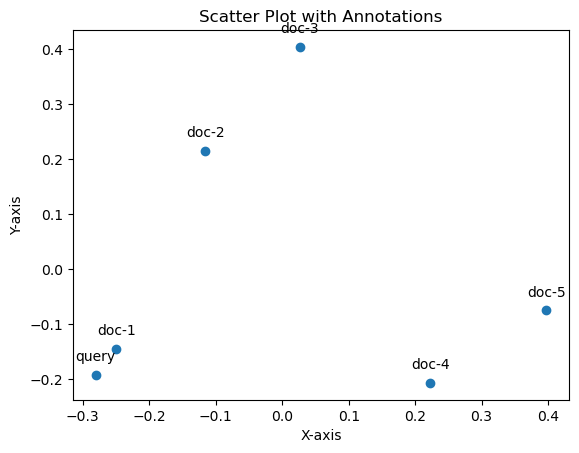

In [68]:
import matplotlib.pyplot as plt

# Sample data
x = new_values[:,0]
y = new_values[:,1]
labels = ['doc-1', 'doc-2', 'doc-3', 'doc-4', 'doc-5', 'query']

# Create scatter plot
plt.scatter(x, y)

# Annotate points with labels
for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Set plot title and labels
plt.title('Scatter Plot with Annotations')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display plot
plt.grid(False)
plt.show()


In [76]:
doc_dict = {'doc-1': split_docs[0],'doc-2': split_docs[1],'doc-3': split_docs[2],'doc-4': split_docs[3],'doc-5': split_docs[4],'query': query}

In [80]:
for doc in doc_dict:
    print(doc)
    print("---------------------------------")
    try:
        print(t[doc].page_content)
    except:
        print(t[doc])
    print("---------------------------------")

doc-1
---------------------------------
What Is Climate Change?  
 
1. Climate change can be a natural process where temperature, rainfall, 
wind and other elements vary over decades or more. In millions of 
years, our world has been warmer and colder than it is now. But today we are experiencing rapid warming from human activities, primarily due 
to burning fossil fuels that generate greenhouse gas emiss ions.  
 
2. Increasing greenhouse gas emissions from human activity act like a 
blanket wrapped around the earth, trapping the sun’s heat and raising 
temperatures.  
 
3. Examples of greenhouse gas emissions that are causing climate 
change include carbon dioxide  and methane. These come from burning 
fossil fuels such as gasoline for driving a car or coal for heating a 
building. Clearing land and forests can also release carbon dioxide. Landfills for garbage are another source. Energy, industry, agriculture 
and was te disposal are among the major emitters.
-----------------------

**As you can see in the above graph that query1 is closely related to doc-1 which is correct.**

**Cosine Similarity in RAG:**

    Definition: Cosine similarity measures the similarity between two vectors in a high-dimensional space.
    
    Application in RAG: Used to compare the similarity between the query and documents in the retrieval process.
    
    Scenarios for Use:
    
    1. Information Retrieval: Effectively retrieves relevant information from a large corpus of documents.
    2. Semantic Similarity: Useful for finding documents that are semantically similar to the query.
    3. Efficient Storage and Retrieval: Optimizes storage and retrieval by using techniques like chunking and indexing.
    4. Enhancing Model Responses: Enriches responses generated by LLMs with relevant information from external databases or knowledge graphs.


**Maximum Marginal Relevance (MMR) in RAG:**

    Definition: A technique to diversify retrieved documents and improve the overall quality of generated responses.
    
    Application in RAG: Balances relevance and diversity in the retrieved documents.
    
    Scenarios for Use:
    1. Diverse Response Generation: Useful for generating varied and diverse responses.
    2. Avoiding Redundancy: Helps in avoiding repetitive information in generated responses.
    3. Balancing Relevance and Diversity: Strikes a balance between relevance and diversity in retrieved documents.
    4. Improving User Experience: Contributes to an enhanced user experience by providing a variety of responses catering to different preferences and requirements.